# Project 3: 'Image Analysis'
## First Year Project  
### ITU, Spring 2021

This notebook contains all the code developed to explore, wrangle and analyse the raw data sets for our project, 'Image Analysis'.

Contributors:  
- Andy Bao Nguyen (anbn)
- Florian Micliuc (flmi)
- Mattias Wohlert 
- Sofia Elena Terenziani (sote)

Created: 06-04-2021 

Last modified:

### Imports

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.cm as cm
from skimage import morphology
from scipy.spatial.distance import cdist
from scipy.stats.stats import mode
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

# Functions

In [2]:
def check_null_values(file, string):
    if file.isnull().values.any():
        print('There are null values in {} dataset'.format(string))
    else:
        print('There are no null values in {} dataset'.format(string))

In [3]:
#Example_ground_truth
#Features
ex_ground = pd.read_csv("../data/raw/example_ground_truth.csv")
features = pd.read_csv("../data/features/features.csv")

In [6]:
check_null_values(ex_ground,'ex_ground')
check_null_values(features,'features')

There are no null values in ex_ground dataset
There are no null values in features dataset


# Loading of data and scripts

In [ ]:
%run ../Scripts/fyp2021p3_group00_functions.py

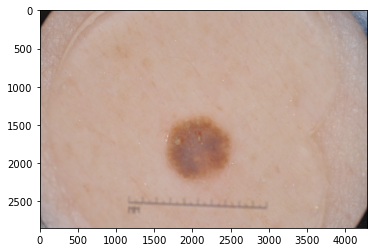

In [7]:
im = plt.imread("../Data/Raw/example_image/ISIC_0014310.jpg")
plt.imshow(im)

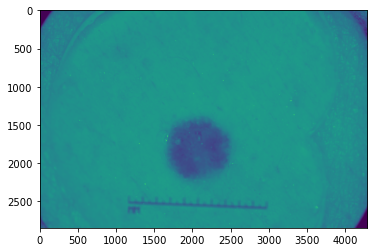

In [11]:
def rgb2gray(rgb):
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    gray = 0.2989 * r * 0.5870 * g + 0.1140 * b
    return gray

grey = rgb2gray(im)
plt.imshow(grey)

# Lesion is darker, and extract a mask of it

(array([[243.,  58., 123., ...,   0.,   0.,   0.],
        [239.,  63., 118., ...,   0.,   0.,   0.],
        [238.,  66., 110., ...,   0.,   0.,   0.],
        ...,
        [284., 195., 182., ...,   0.,   0.,   0.],
        [282., 199., 180., ...,   0.,   0.,   0.],
        [285., 203., 171., ...,   0.,   0.,   0.]]),
 array([   52.8722927 ,  1191.36084918,  2329.84940566,  3468.33796214,
         4606.82651862,  5745.3150751 ,  6883.80363158,  8022.29218806,
         9160.78074454, 10299.26930102, 11437.7578575 ]),
 <a list of 4288 BarContainer objects>)

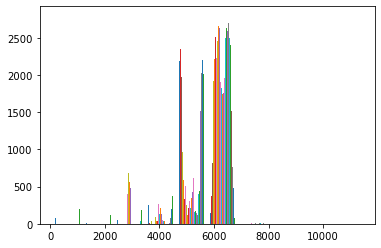

In [9]:
plt.hist(grey)
# Will run for a minute or two

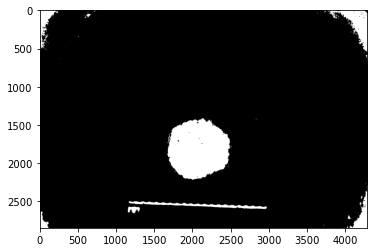

In [10]:
# Our lesion is in the smaller clusters (The darker pixels), and the greater ones must be the pixels of the skin
im_lim = grey < 4500
plt.imshow(im_lim, cmap = "gray") # We see a little noice within our lesion